`class_likelihood_ratios` function computers the positive and negative likelihood ration `LR+` and `LR-` to assess the predictive power of a binary classifier.
- Useful because, these metrics are independent of the proportion between classes in the test set. 

#### Pre-test vs Post-test analysis

###### Suppose we have a population of subjects with physiological measurements X that can hopefully serve as indirect bio-markers of the disease and actual disease indicators y (ground truth). Most of the people in the population do not carry the disease but a minority (in this case around 10%) does:

In [1]:
from sklearn.datasets import make_classification 

X, y = make_classification(n_samples=10_000, weights=[0.9,0.1], random_state=0)
print(f"Percentage of people carrying disease: {100*y.mean():.2f}%")

Percentage of people carrying disease: 10.37%


In [2]:
#To evaluate the model, we need to assess its performance on a hold-out test set
# Fit our diagnosis model, and compute the positive likelihood ratio to evaluate the usefulness of this classifier

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
from sklearn.metrics import class_likelihood_ratios 
from sklearn.linear_model import LogisticRegression 

estimator = LogisticRegression().fit(X_train, y_train)
y_pred = estimator.predict(X_test)
pos_LR, neg_LR = class_likelihood_ratios(y_test, y_pred)
print(f"LR+ positive likelihood: {pos_LR:.3f}")

LR+ positive likelihood: 12.617


#### Cross-validatioin of likelihood ratios

In [4]:
import pandas as pd 

def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    pos_lr, neg_lr = class_likelihood_ratios(y, y_pred, raise_warning=False)
    return{"positive_likelihood_ratio": pos_lr, "negative_likelihood_ratio": neg_lr}

def extract_score(cv_results):
    lr = pd.DataFrame(
        {
        "positive":cv_results["test_positive_likelihood_ratio"],
        "negative":cv_results["test_negative_likelihood_ratio"],
        }
    )
    return lr.aggregate(["mean","std"])


In [5]:
from sklearn.model_selection import cross_validate 

estimator = LogisticRegression()
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,16.718894,0.724619
std,4.321091,0.054054


In [6]:
#If we make some changes 

estimator = LogisticRegression()
X, y = make_classification(n_samples=300, weights=[0.9,0.1], random_state=0)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))


,positive,negative
mean,17.8000,0.373333
std,8.5557,0.235430


#### Invariance with respect to prevalence
- The likelihhod ratios are inpedendent of the disease prevalence regardless of any class imbalance 
- Here, first we train a base model of `LogisticRegression` with 50% prevalence, and evaluate it over population with <i>variying prevalence</i>
- `1` => positive class - disease
- `0` => negative class - no-disease

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.inspection import DecisionBoundaryDisplay 
from collections import defaultdict 

In [8]:
#key inputs to models

population = defaultdict(list)
common_param = {"n_samples": 10_000, "n_features": 2, "n_informative": 2, "n_redundant": 0, "random_state": 0}
weights = np.linspace(0.1, 0.8, 6)
weights = weights[::-1]

In [9]:
#fitting and evaluating on the base model - logistic 

X, y = make_classification(**common_param, weights=[0.5, 0.5])
estimator = LogisticRegression().fit(X,y)
lr_base = extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))
pos_lr_base, pos_lr_base_std = lr_base["positive"].values 
neg_lr_base, neg_lr_base_std = lr_base["negative"].values 

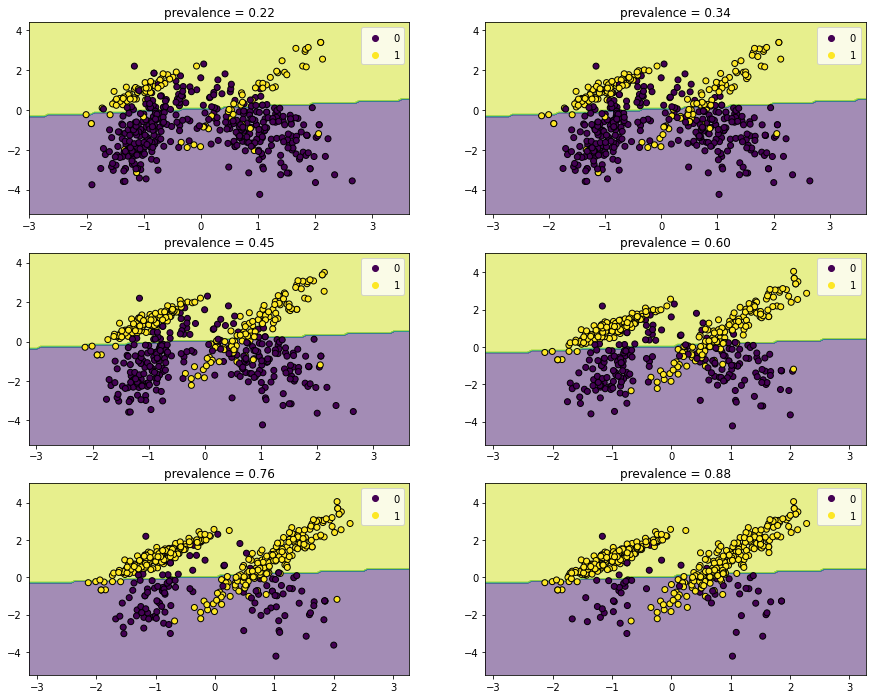

In [10]:
#visualizing decision boundary for each level of prevalece

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

for ax, (n, weight) in zip(ax.ravel(), enumerate(weights)):
    X, y = make_classification(**common_param, weights=[weight, 1 - weight])
    prevalence = y.mean()
    population["prevalence"].append(prevalence)
    population["X"].append(X)
    population["y"].append(y)

    #down-sampling for plotting 
    rng = np.random.RandomState(1)
    plot_indices = rng.choice(np.arange(X.shape[0]), size=500, replace=True)
    X_plot, y_plot = X[plot_indices], y[plot_indices]


    #plot fixed decision boundary of base model with varying prevalence 
    disp = DecisionBoundaryDisplay.from_estimator(estimator, X_plot, response_method="predict", alpha =0.5, ax = ax)
    scatter = disp.ax_.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolor="k")
    disp.ax_.set_title(f"prevalence = {y_plot.mean():.2f}")
    disp.ax_.legend(*scatter.legend_elements())


Next, defining a function for bootstrapping

In [11]:
def scoring_on_bootstrap(estimator, X, y, rng, n_bootstrap=100):
    results_for_prevalence = defaultdict(list)
    for _ in range(n_bootstrap):
        bootstrap_indices = rng.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
        for key, value in scoring(estimator, X[bootstrap_indices], y[bootstrap_indices]).items():
            results_for_prevalence[key].append(value)
    return pd.DataFrame(results_for_prevalence)

#### Now, comparing base model with 50% prevalence with other varying prevalence base model

In [12]:
results = defaultdict(list)
n_bootstrap = 100
rng = np.random.default_rng(seed=0)

for prevalence, X, y in zip(population["prevalence"], population["X"], population["y"]):
    results_for_prevalence = scoring_on_bootstrap(estimator, X, y, rng, n_bootstrap=n_bootstrap)
    results["prevalence"].append(prevalence)
    results["metrics"].append(results_for_prevalence.aggregate(["mean", "std"]).unstack())

results = pd.DataFrame(results["metrics"], index=results["prevalence"])
results.index.name = "prevalence"
results



positive_likelihood_ratio           negative_likelihood_ratio  \
                                mean       std                      mean   
prevalence                                                                 
0.2039                      4.507943  0.113516                  0.207667   
0.3419                      4.445329  0.125197                  0.198280   
0.4809                      4.422287  0.123864                  0.192630   
0.6196                      4.410507  0.163975                  0.193761   
0.7578                      4.335398  0.175224                  0.189120   
0.8963                      4.198284  0.238943                  0.185496   

                      
                 std  
prevalence            
0.2039      0.009778  
0.3419      0.008907  
0.4809      0.006340  
0.6196      0.005864  
0.7578      0.005820  
0.8963      0.005020

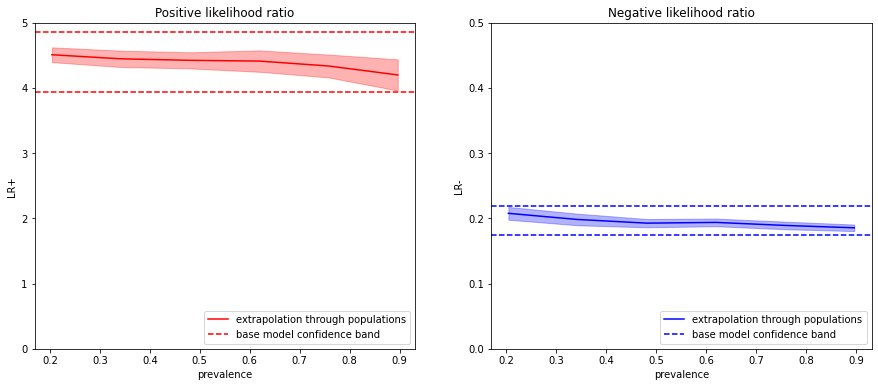

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
results["positive_likelihood_ratio"]["mean"].plot(
    ax=ax1, color="r", label="extrapolation through populations"
)
ax1.axhline(y=pos_lr_base + pos_lr_base_std, color="r", linestyle="--")
ax1.axhline(y=pos_lr_base - pos_lr_base_std, color="r", linestyle="--", label="base model confidence band")
ax1.fill_between(results.index,
    results["positive_likelihood_ratio"]["mean"] - results["positive_likelihood_ratio"]["std"],
    results["positive_likelihood_ratio"]["mean"] + results["positive_likelihood_ratio"]["std"],
    color="r", alpha=0.3)
ax1.set(title="Positive likelihood ratio", ylabel="LR+", ylim=[0, 5])
ax1.legend(loc="lower right")

ax2 = results["negative_likelihood_ratio"]["mean"].plot(ax=ax2, color="b", label="extrapolation through populations")
ax2.axhline(y=neg_lr_base + neg_lr_base_std, color="b", linestyle="--")
ax2.axhline(y=neg_lr_base - neg_lr_base_std, color="b", linestyle="--", label="base model confidence band")
ax2.fill_between(results.index,
    results["negative_likelihood_ratio"]["mean"] - results["negative_likelihood_ratio"]["std"],
    results["negative_likelihood_ratio"]["mean"] + results["negative_likelihood_ratio"]["std"],
    color="b", alpha=0.3)
ax2.set(title="Negative likelihood ratio", ylabel="LR-", ylim=[0, 0.5],)
ax2.legend(loc="lower right")

plt.show()